In [ ]:
import gdown
import zipfile
import os

# 1. LOD_coco.zip 다운로드 및 압축 해제

# 구글 드라이브 공유 링크
# https://drive.google.com/file/d/1NeJ4roqdLMPkBcw7t-mF1Tvo3Sdlt8k6/view?usp=sharing
lod_coco_file_id = '1NeJ4roqdLMPkBcw7t-mF1Tvo3Sdlt8k6'
lod_coco_url = f'https://drive.google.com/uc?id={lod_coco_file_id}'

lod_coco_output = 'LOD_coco.zip'
print("Downloading LOD_coco.zip...")
gdown.download(lod_coco_url, lod_coco_output, quiet=False)

print("Extracting LOD_coco.zip...")
with zipfile.ZipFile(lod_coco_output, 'r') as zip_ref:
    zip_ref.extractall('.')

os.remove(lod_coco_output)
print("LOD_coco.zip downloaded and extracted successfully.\n")

# 2. best.pt 다운로드 및 저장

# best.pt 구글 드라이브 공유 링크
# https://drive.google.com/file/d/1KvD4aU8emrFgHiWddKT34XPVOnH72Neo/view?usp=sharing
best_pt_file_id = '1KvD4aU8emrFgHiWddKT34XPVOnH72Neo'  # 실제 파일 ID로 교체해야 합니다.
best_pt_url = f'https://drive.google.com/uc?id={best_pt_file_id}'

weights_dir = './weights'
best_pt_path = os.path.join(weights_dir, 'best.pt')
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)
    print(f"Created directory: {weights_dir}")

print("Downloading best.pt...")
gdown.download(best_pt_url, best_pt_path, quiet=False)
print(f"best.pt has been saved to {best_pt_path}.\n")


# Object detection (YOLOv8 PyTorch)

![yolov8](https://github.com/ultralytics/docs/releases/download/0/yolov8-comparison-plots.avif)


In [1]:
import copy
import math
import random
import time
import os
import csv
import warnings
import numpy as np

import cv2
import torch
import torchvision
from PIL import Image
from torch.nn.functional import cross_entropy, one_hot
from torch.utils import data
from tqdm import tqdm

warnings.filterwarnings("ignore")


## Hyperparameter settings

In [2]:
params = {
    'lr0': 0.001,            # 초기 learning rate (Adam에서 주로 1e-3)
    'weight_decay': 0.0005,  # Adam weight decay
    'box': 7.5,              # box loss 가중치
    'cls': 0.5,              # cls loss 가중치
    'dfl': 1.5,              # dfl loss 가중치
    'hsv_h': 0.015,          # HSV Hue augmentation
    'hsv_s': 0.70,           # HSV Saturation augmentation
    'hsv_v': 0.40,           # HSV Value augmentation
    'degrees': 0.0,          # 이미지 회전 범위
    'translate': 0.1,        # 이미지 평행이동 범위
    'scale': 0.5,            # 이미지 확대/축소 범위
    'shear': 0.0,            # 이미지 Shear 범위
    'flip_ud': 0.0,          # 상하 반전 확률
    'flip_lr': 0.5,          # 좌우 반전 확률
    'mosaic': 1.0,           # mosaic augmentation 확률
    'mix_up': 0.0,           # mix_up augmentation 확률
    'names': {               # 클래스 이름들
        0: 'chair',
        1: 'diningtable',
        2: 'car',
        3: 'motorbike',
        4: 'bycicle',
        5: 'bus',
        6: 'bottle',
        7: 'tvmonitor'
    }
}


## Utility functions

In [3]:
def setup_seed(seed=0):
    """
    Setup random seed to ensure reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


In [4]:
def scale(coords, shape1, shape2, ratio_pad=None):
    """
    예측된 박스(coords)를 원본 이미지 크기(shape2)에 맞추어 스케일 조정합니다.
    shape1은 현재 이미지의 shape, shape2는 원본의 shape.
    """
    if ratio_pad is None:
        gain = min(shape1[0] / shape2[0], shape1[1] / shape2[1]) 
        pad = ((shape1[1] - shape2[1] * gain) / 2, (shape1[0] - shape2[0] * gain) / 2)
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  
    coords[:, [1, 3]] -= pad[1]  
    coords[:, :4] /= gain

    coords[:, 0].clamp_(0, shape2[1])  
    coords[:, 1].clamp_(0, shape2[0])  
    coords[:, 2].clamp_(0, shape2[1])  
    coords[:, 3].clamp_(0, shape2[0])  
    return coords


In [5]:
def make_anchors(x, strides, offset=0.5):
    """
    출력 feature map을 기반으로 앵커 좌표를 만드는 함수
    """
    assert x is not None
    anchor_points, stride_tensor = [], []
    for i, stride in enumerate(strides):
        _, _, h, w = x[i].shape
        sx = torch.arange(end=w, dtype=x[i].dtype, device=x[i].device) + offset
        sy = torch.arange(end=h, dtype=x[i].dtype, device=x[i].device) + offset
        sy, sx = torch.meshgrid(sy, sx)
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=x[i].dtype, device=x[i].device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)


In [6]:
def wh2xy_(x):
    """
    [cx, cy, w, h] -> [x1, y1, x2, y2]
    """
    y = x.clone()
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y


### IoU(Intersection over Union)

![IoU](https://blog.kakaocdn.net/dn/I9MIb/btq9eMfNYbF/KeQxOsQydbNkZuRNhoMv9k/img.png)

In [7]:
def box_iou(box1, box2):
    """
    두 박스 집합의 IoU를 계산합니다.
    box1: (N,4), box2: (M,4)
    """
    (a1, a2), (b1, b2) = box1[:, None].chunk(2, 2), box2.chunk(2, 1)
    intersection = (torch.min(a2, b2) - torch.max(a1, b1)).clamp(0).prod(2)

    box1 = box1.T
    box2 = box2.T
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    return intersection / (area1[:, None] + area2 - intersection)


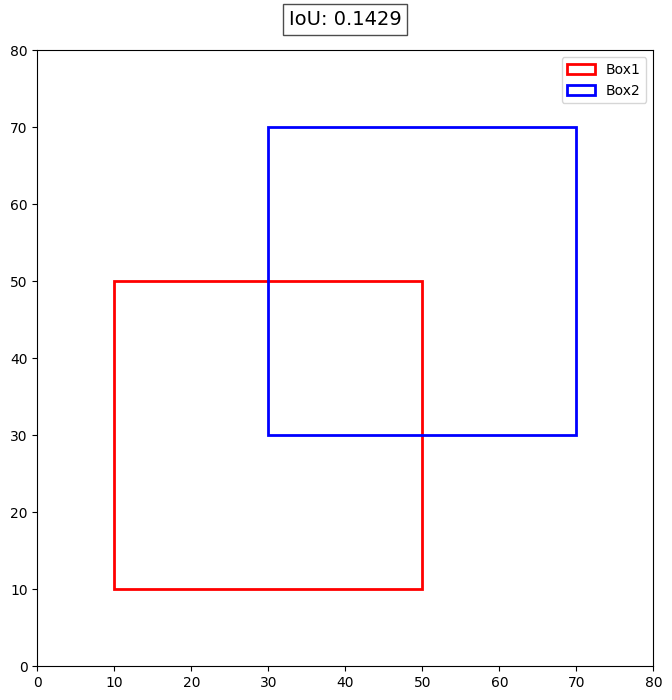

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_boxes_and_iou(box1, box2, iou_fn):
    """
    위에서 만든 IoU 함수를 활용하여 두 박스의 교집합과 IoU를 시각화합니다.
    Args:
        box1 (Tensor): 첫 번째 박스 (1, 4) 크기.
        box2 (Tensor): 두 번째 박스 (1, 4) 크기.
        iou_fn (callable): IoU 계산.
    """
    # IoU 계산
    iou_value = iou_fn(box1.unsqueeze(0), box2.unsqueeze(0))

    # 박스 시각화
    fig, ax = plt.subplots(1, figsize=(8, 8))

    # 박스 1
    rect1 = patches.Rectangle((box1[0], box1[1]), box1[2] - box1[0], box1[3] - box1[1],
                               linewidth=2, edgecolor='r', facecolor='none', label='Box1')
    ax.add_patch(rect1)

    # 박스 2
    rect2 = patches.Rectangle((box2[0], box2[1]), box2[2] - box2[0], box2[3] - box2[1],
                               linewidth=2, edgecolor='b', facecolor='none', label='Box2')
    ax.add_patch(rect2)

    # IoU 값 표시
    ax.text(0.5, 1.05, f"IoU: {iou_value.item():.4f}", transform=ax.transAxes, fontsize=14,
            verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.7))

    # 설정
    ax.set_xlim(0, max(box1[2], box2[2]) + 10)
    ax.set_ylim(0, max(box1[3], box2[3]) + 10)
    ax.set_aspect('equal')
    plt.legend()
    plt.show()

# 예제
box1 = torch.tensor([10, 10, 50, 50]) 
box2 = torch.tensor([30, 30, 70, 70]) 

visualize_boxes_and_iou(box1, box2, box_iou)


### NMS (Non-Maximum Suppression)

![nms1](https://wikidocs.net/images/page/142645/NMS.png)

In [9]:
import torch
import torchvision
import time

def non_max_suppression(prediction, conf_threshold=0.25, iou_threshold=0.45):
    """
    Non-Maximum Suppression (NMS)를 수행하여 중복된 박스를 제거합니다.
    Args:
        prediction (Tensor): 모델 예측값 (batch_size, num_predictions, 4+num_classes).
        conf_threshold (float): Confidence score 임계값.
        iou_threshold (float): IoU 임계값.
    Returns:
        List[Tensor]: 이미지별 NMS가 적용된 박스 리스트.
    """
    nc = prediction.shape[1] - 4  # 클래스 수
    xc = prediction[:, 4:4 + nc].amax(1) > conf_threshold  # Confidence 필터링

    max_wh = 7680  # 최대 offset
    max_det = 300  # 최대 detection 개수
    max_nms = 30000  # NMS에서 허용되는 최대 박스 수

    start = time.time()
    outputs = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for index, x in enumerate(prediction):
        # Confidence score를 기반으로 박스 필터링
        x = x.transpose(0, -1)[xc[index]]
        if not x.shape[0]:
            continue

        # 좌표 변환
        box, cls = x.split((4, nc), 1)
        box = wh2xy_(box)

        # 클래스 기반 필터링
        if nc > 1:
            i, j = (cls > conf_threshold).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float()), 1)
        else:
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_threshold]

        if not x.shape[0]:
            continue

        # NMS를 위한 상위 박스 선택
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        c = x[:, 5:6] * max_wh  # offset 추가
        boxes, scores = x[:, :4] + c, x[:, 4]

        # NMS 수행
        i = torchvision.ops.nms(boxes, scores, iou_threshold)
        i = i[:max_det]  # 최대 detection 수 제한
        outputs[index] = x[i]

        # 타임아웃 확인
        if (time.time() - start) > 0.5 + 0.05 * prediction.shape[0]:
            print(f'WARNING ⚠️ NMS time limit exceeded')
            break

    return outputs


## Metric

In [10]:
def smooth(y, f=0.05):
    """
    박스 필터 기반 스무딩
    """
    nf = round(len(y) * f * 2) // 2 + 1
    p = np.ones(nf // 2)
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)
    return np.convolve(yp, np.ones(nf) / nf, mode='valid')


def compute_ap(tp, conf, pred_cls, target_cls, eps=1e-16):
    """
    mAP를 계산하는 함수.
    Args:
        tp (ndarray): True Positive 배열.
        conf (ndarray): Confidence score 배열.
        pred_cls (ndarray): 예측된 클래스 배열.
        target_cls (ndarray): 실제 클래스 배열.
    Returns:
        tuple: TP, FP, Precision, Recall, mAP@0.5, 평균 mAP.
    """
    # Confidence 점수를 기준으로 데이터 정렬
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # 고유 클래스 및 클래스별 데이터 초기화
    unique_classes, nt = np.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]

    p = np.zeros((nc, 1000))  # Precision
    r = np.zeros((nc, 1000))  # Recall
    ap = np.zeros((nc, tp.shape[1]))  # Average Precision
    px = np.linspace(0, 1, 1000)  # Recall-Precision 곡선용 구간

    # 클래스별 Precision, Recall 계산
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c  # 현재 클래스의 예측 인덱스
        nl = nt[ci]        # 실제 레이블 개수
        no = i.sum()       # 예측 레이블 개수
        if no == 0 or nl == 0:
            continue

        # TP, FP 누적 계산
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall 및 Precision 계산
        recall = tpc / (nl + eps)
        r[ci] = np.interp(-px, -conf[i], recall[:, 0], left=0)
        precision = tpc / (tpc + fpc)
        p[ci] = np.interp(-px, -conf[i], precision[:, 0], left=1)

        # AP 계산
        for j in range(tp.shape[1]):
            m_rec = np.concatenate(([0.0], recall[:, j], [1.0]))
            m_pre = np.concatenate(([1.0], precision[:, j], [0.0]))
            m_pre = np.flip(np.maximum.accumulate(np.flip(m_pre)))  # Precision 보정
            x = np.linspace(0, 1, 101)
            ap[ci, j] = np.trapz(np.interp(x, m_rec, m_pre), x)

    # F1 점수 계산
    f1 = 2 * p * r / (p + r + eps)
    i = smooth(f1.mean(0), 0.1).argmax()
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()
    fp = (tp / (p + eps) - tp).round()

    # mAP@0.5 및 평균 mAP 계산
    ap50, ap_mean = ap[:, 0], ap.mean(1)
    map50, mean_ap = ap50.mean(), ap_mean.mean()

    return tp, fp, p.mean(), r.mean(), map50, mean_ap


In [11]:
def strip_optimizer(filename):
    """
    최종 배포 시 필요 없는 optimizer 상태 등 제거
    """
    x = torch.load(filename, map_location=torch.device('cpu'))
    x['model'].half()
    for p in x['model'].parameters():
        p.requires_grad = False
    torch.save(x, filename)


class AverageMeter:
    """
    평균값을 간단히 관리하는 클래스
    """
    def __init__(self):
        self.num = 0
        self.sum = 0
        self.avg = 0

    def update(self, v, n):
        if not math.isnan(float(v)):
            self.num += n
            self.sum += v * n
            self.avg = self.sum / self.num


## Loss
* Classification Loss (cls loss)
    * Binary Cross Entropy (BCE)
    * Use a weight of 0.5

* IoU Loss (box loss)
    * Complete IoU (CIoU)
    * Use a weight of 7.5

* Distribution Focal Loss (dfl loss)
    * Predict the probability distribution of bounding box coordinates.
    * Use a weight of 1.5
    * ![dfl](https://velog.velcdn.com/images/d4r6j/post/26ffd850-8ea0-40df-a4b4-51e0053be4df/image.png)

In [12]:
class ComputeLoss:
    def __init__(self, model, params):
        super().__init__()
        if hasattr(model, 'module'):
            model = model.module

        device = next(model.parameters()).device
        m = model.head  
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.stride = m.stride
        self.nc = m.nc
        self.no = m.no
        self.device = device
        self.params = params
        self.top_k = 10
        self.alpha = 0.5
        self.beta = 6.0
        self.eps = 1e-9
        self.bs = 1
        self.num_max_boxes = 0
        self.dfl_ch = m.dfl.ch
        self.project = torch.arange(self.dfl_ch, dtype=torch.float, device=device)

    def __call__(self, outputs, targets):
        x = outputs[1] if isinstance(outputs, tuple) else outputs
        output = torch.cat([i.view(x[0].shape[0], self.no, -1) for i in x], 2)
        pred_output, pred_scores = output.split((4 * self.dfl_ch, self.nc), 1)

        pred_output = pred_output.permute(0, 2, 1).contiguous()
        pred_scores = pred_scores.permute(0, 2, 1).contiguous()

        size = torch.tensor(x[0].shape[2:], dtype=pred_scores.dtype, device=self.device)
        size = size * self.stride[0]
        anchor_points, stride_tensor = make_anchors(x, self.stride, 0.5)

        # targets
        if targets.shape[0] == 0:
            gt = torch.zeros(pred_scores.shape[0], 0, 5, device=self.device)
        else:
            i = targets[:, 0]
            _, counts = i.unique(return_counts=True)
            gt = torch.zeros(pred_scores.shape[0], counts.max(), 5, device=self.device)
            for j in range(pred_scores.shape[0]):
                matches = i == j
                n = matches.sum()
                if n:
                    gt[j, :n] = targets[matches, 1:]
            gt[..., 1:5] = wh2xy_(gt[..., 1:5].mul_(size[[1, 0, 1, 0]]))

        gt_labels, gt_bboxes = gt.split((1, 4), 2)
        mask_gt = gt_bboxes.sum(2, keepdim=True).gt_(0)

        b, a, c = pred_output.shape
        pred_bboxes = pred_output.view(b, a, 4, c // 4).softmax(3)
        pred_bboxes = pred_bboxes.matmul(self.project.type(pred_bboxes.dtype))
        a, b = torch.split(pred_bboxes, 2, -1)
        pred_bboxes = torch.cat((anchor_points - a, anchor_points + b), -1)

        scores = pred_scores.detach().sigmoid()
        bboxes = (pred_bboxes.detach() * stride_tensor).type(gt_bboxes.dtype)
        target_bboxes, target_scores, fg_mask = self.assign(scores, bboxes,
                                                            gt_labels, gt_bboxes, mask_gt,
                                                            anchor_points * stride_tensor)

        target_bboxes /= stride_tensor
        target_scores_sum = target_scores.sum()

        # cls loss
        loss_cls = self.bce(pred_scores, target_scores.to(pred_scores.dtype))
        loss_cls = loss_cls.sum() / (target_scores_sum + self.eps)

        # iou loss, dfl loss
        loss_box = torch.zeros(1, device=self.device)
        loss_dfl = torch.zeros(1, device=self.device)
        if fg_mask.sum():
            weight = torch.masked_select(target_scores.sum(-1), fg_mask).unsqueeze(-1)
            loss_box = self.iou(pred_bboxes[fg_mask], target_bboxes[fg_mask])
            loss_box = ((1.0 - loss_box) * weight).sum() / (target_scores_sum + self.eps)
            a, b = torch.split(target_bboxes, 2, -1)
            target_lt_rb = torch.cat((anchor_points - a, b - anchor_points), -1)
            target_lt_rb = target_lt_rb.clamp(0, self.dfl_ch - 1.01)
            loss_dfl = self.df_loss(pred_output[fg_mask].view(-1, self.dfl_ch), target_lt_rb[fg_mask])
            loss_dfl = (loss_dfl * weight).sum() / (target_scores_sum + self.eps)

        loss_cls *= self.params['cls']
        loss_box *= self.params['box']
        loss_dfl *= self.params['dfl']

        return loss_cls + loss_box + loss_dfl

    @torch.no_grad()
    def assign(self, pred_scores, pred_bboxes, true_labels, true_bboxes, true_mask, anchors):
        self.bs = pred_scores.size(0)
        self.num_max_boxes = true_bboxes.size(1)
        if self.num_max_boxes == 0:
            device = true_bboxes.device
            target_bboxes = torch.zeros_like(pred_bboxes).to(device)
            target_scores = torch.zeros_like(pred_scores).to(device)
            fg_mask = torch.zeros_like(pred_scores[..., 0]).to(device)
            return target_bboxes, target_scores, fg_mask

        i = torch.zeros([2, self.bs, self.num_max_boxes], dtype=torch.long)
        i[0] = torch.arange(end=self.bs).view(-1, 1).repeat(1, self.num_max_boxes)
        i[1] = true_labels.long().squeeze(-1)
        overlaps = self.iou(true_bboxes.unsqueeze(2), pred_bboxes.unsqueeze(1)).squeeze(3).clamp(0)
        align_metric = pred_scores[i[0], :, i[1]].pow(self.alpha) * overlaps.pow(self.beta)

        bs, n_boxes, _ = true_bboxes.shape
        lt, rb = true_bboxes.view(-1, 1, 4).chunk(2, 2)
        bbox_deltas = torch.cat((anchors[None] - lt, rb - anchors[None]), dim=2)
        mask_in_gts = bbox_deltas.view(bs, n_boxes, anchors.shape[0], -1).amin(3).gt_(1e-9)
        metrics = align_metric * mask_in_gts
        top_k_metrics, top_k_indices = torch.topk(metrics, self.top_k, dim=-1, largest=True)
        is_in_top_k = one_hot(top_k_indices, anchors.shape[0]).sum(-2)
        is_in_top_k = torch.where(is_in_top_k > 1, 0, is_in_top_k)
        mask_top_k = is_in_top_k.to(metrics.dtype)
        mask_pos = mask_top_k * mask_in_gts * true_mask
        fg_mask = mask_pos.sum(-2)
        if fg_mask.max() > 1:
            mask_multi_gts = (fg_mask.unsqueeze(1) > 1).repeat([1, self.num_max_boxes, 1])
            max_overlaps_idx = overlaps.argmax(1)
            is_max_overlaps = one_hot(max_overlaps_idx, self.num_max_boxes)
            is_max_overlaps = is_max_overlaps.permute(0, 2, 1).to(overlaps.dtype)
            mask_pos = torch.where(mask_multi_gts, is_max_overlaps, mask_pos)
            fg_mask = mask_pos.sum(-2)
        target_gt_idx = mask_pos.argmax(-2)
        batch_index = torch.arange(end=self.bs, dtype=torch.int64, device=true_labels.device)[..., None]
        target_gt_idx = target_gt_idx + batch_index * self.num_max_boxes
        target_labels = true_labels.long().flatten()[target_gt_idx]
        target_bboxes = true_bboxes.view(-1, 4)[target_gt_idx]
        target_labels.clamp(0)
        target_scores = one_hot(target_labels, self.nc)
        fg_scores_mask = fg_mask[:, :, None].repeat(1, 1, self.nc)
        target_scores = torch.where(fg_scores_mask > 0, target_scores, 0)
        align_metric *= mask_pos
        pos_align_metrics = align_metric.amax(axis=-1, keepdim=True)
        pos_overlaps = (overlaps * mask_pos).amax(axis=-1, keepdim=True)
        norm_align_metric = (align_metric * pos_overlaps / (pos_align_metrics + self.eps)).amax(-2).unsqueeze(-1)
        target_scores = target_scores * norm_align_metric
        return target_bboxes, target_scores, fg_mask.bool()

    @staticmethod
    def df_loss(pred_dist, target):
        tl = target.long()
        tr = tl + 1
        wl = tr - target
        wr = 1 - wl
        l_loss = cross_entropy(pred_dist, tl.view(-1), reduction="none").view(tl.shape)
        r_loss = cross_entropy(pred_dist, tr.view(-1), reduction="none").view(tl.shape)
        return (l_loss * wl + r_loss * wr).mean(-1, keepdim=True)

    @staticmethod
    def iou(box1, box2, eps=1e-7):
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
        area1 = b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)
        area2 = b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)
        intersection = area1.clamp(0) * area2.clamp(0)
        union = w1 * h1 + w2 * h2 - intersection + eps
        iou = intersection / union
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)
        c2 = cw ** 2 + ch ** 2 + eps
        rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4
        v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
        with torch.no_grad():
            alpha = v / (v - iou + (1 + eps))
        return iou - (rho2 / c2 + v * alpha)


In [13]:
def tensor_to_image(tensor):
    """
    (C,H,W) 텐서를 (H,W,C) uint8 이미지로 변환
    """
    tensor = tensor.squeeze().cpu().numpy()
    return (tensor * 255).astype(np.uint8)

def pad(k, p=None, d=1):
    """
    커널 크기(k)와 dilation(d)에 따른 패딩 계산.
    """
    if d > 1:
        k = d * (k - 1) + 1
    if p is None:
        p = k // 2
    return p


## Model
* Backbone-FPN-Head 구조

![yolov8 model](https://github.com/Gwangiksin/ml_cv/blob/master/img/yolov8.png?raw=true)



### Basic blocks


In [14]:
def fuse_conv(conv, norm):
    """
    Conv와 BatchNorm 파라미터를 합치는 함수.
    추론에서만 사용 (모델 경량화)
    """
    fused_conv = torch.nn.Conv2d(conv.in_channels,
                                 conv.out_channels,
                                 kernel_size=conv.kernel_size,
                                 stride=conv.stride,
                                 padding=conv.padding,
                                 groups=conv.groups,
                                 bias=True).requires_grad_(False).to(conv.weight.device)

    w_conv = conv.weight.clone().view(conv.out_channels, -1)
    w_norm = torch.diag(norm.weight.div(torch.sqrt(norm.running_var + norm.eps)))
    fused_conv.weight.copy_(torch.mm(w_norm, w_conv).view(fused_conv.weight.size()))

    b_conv = torch.zeros(conv.weight.size(0), device=conv.weight.device) if conv.bias is None else conv.bias
    b_norm = norm.bias - norm.weight.mul(norm.running_mean).div(torch.sqrt(norm.running_var + norm.eps))
    fused_conv.bias.copy_(torch.mm(w_norm, b_conv.reshape(-1, 1)).reshape(-1) + b_norm)
    return fused_conv


class Conv(torch.nn.Module):
    def __init__(self, in_ch, out_ch, k=1, s=1, p=None, d=1, g=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, k, s, pad(k, p, d), d, g, bias=False)
        self.norm = torch.nn.BatchNorm2d(out_ch, 0.001, 0.03)
        self.relu = torch.nn.SiLU(inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))

    def fuse_forward(self, x):
        return self.relu(self.conv(x))
    
class Residual(torch.nn.Module):
    def __init__(self, ch, add=True):
        super().__init__()
        self.add_m = add
        self.res_m = torch.nn.Sequential(
            Conv(ch, ch, 3),
            Conv(ch, ch, 3)
        )

    def forward(self, x):
        return self.res_m(x) + x if self.add_m else self.res_m(x)


class CSP(torch.nn.Module):
    """
    Cross Stage Partial 네트워크 구성 블록
    """
    def __init__(self, in_ch, out_ch, n=1, add=True):
        super().__init__()
        self.conv1 = Conv(in_ch, out_ch // 2)
        self.conv2 = Conv(in_ch, out_ch // 2)
        self.conv3 = Conv((2 + n) * out_ch // 2, out_ch)
        self.res_m = torch.nn.ModuleList(Residual(out_ch // 2, add) for _ in range(n))

    def forward(self, x):
        y = [self.conv1(x), self.conv2(x)]
        y.extend(m(y[-1]) for m in self.res_m)
        return self.conv3(torch.cat(y, dim=1))


class SPP(torch.nn.Module):
    """
    Spatial Pyramid Pooling
    """
    def __init__(self, in_ch, out_ch, k=5):
        super().__init__()
        self.conv1 = Conv(in_ch, in_ch // 2)
        self.conv2 = Conv(in_ch * 2, out_ch)
        self.res_m = torch.nn.MaxPool2d(k, 1, k // 2)

    def forward(self, x):
        x = self.conv1(x)
        y1 = self.res_m(x)
        y2 = self.res_m(y1)
        return self.conv2(torch.cat([x, y1, y2, self.res_m(y2)], 1))


### Backbone & Neck
![fpn](https://wikidocs.net/images/page/162976/FPN_1.PNG)

#### TODO
* Change the backbone from DarkNet to ResNet18.

In [15]:
class DarkNet(torch.nn.Module):
    """
    YOLOv8 Backbone
    """
    def __init__(self, width, depth):
        super().__init__()
        p1 = [Conv(width[0], width[1], 3, 2)]
        p2 = [Conv(width[1], width[2], 3, 2), CSP(width[2], width[2], depth[0])]
        p3 = [Conv(width[2], width[3], 3, 2), CSP(width[3], width[3], depth[1])]
        p4 = [Conv(width[3], width[4], 3, 2), CSP(width[4], width[4], depth[2])]
        p5 = [Conv(width[4], width[5], 3, 2), CSP(width[5], width[5], depth[0]), SPP(width[5], width[5])]

        self.p1 = torch.nn.Sequential(*p1)
        self.p2 = torch.nn.Sequential(*p2)
        self.p3 = torch.nn.Sequential(*p3)
        self.p4 = torch.nn.Sequential(*p4)
        self.p5 = torch.nn.Sequential(*p5)

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2(p1)
        p3 = self.p3(p2)
        p4 = self.p4(p3)
        p5 = self.p5(p4)
        return p3, p4, p5


class DarkFPN(torch.nn.Module):
    """
    Feature Pyramid Network
    """
    def __init__(self, width, depth):
        super().__init__()
        self.up = torch.nn.Upsample(None, 2)
        self.h1 = CSP(width[4] + width[5], width[4], depth[0], False)
        self.h2 = CSP(width[3] + width[4], width[3], depth[0], False)
        self.h3 = Conv(width[3], width[3], 3, 2)
        self.h4 = CSP(width[3] + width[4], width[4], depth[0], False)
        self.h5 = Conv(width[4], width[4], 3, 2)
        self.h6 = CSP(width[4] + width[5], width[5], depth[0], False)

    def forward(self, x):
        p3, p4, p5 = x
        h1 = self.h1(torch.cat([self.up(p5), p4], 1))
        h2 = self.h2(torch.cat([self.up(h1), p3], 1))
        h4 = self.h4(torch.cat([self.h3(h2), h1], 1))
        h6 = self.h6(torch.cat([self.h5(h4), p5], 1))
        return h2, h4, h6


### Head

In [16]:
class DFL(torch.nn.Module):
    """
    Integral module for Distribution Focal Loss
    """
    def __init__(self, ch=16):
        super().__init__()
        self.ch = ch
        self.conv = torch.nn.Conv2d(ch, 1, 1, bias=False).requires_grad_(False)
        x = torch.arange(ch, dtype=torch.float).view(1, ch, 1, 1)
        self.conv.weight.data[:] = torch.nn.Parameter(x)

    def forward(self, x):
        b, c, a = x.shape
        x = x.view(b, 4, self.ch, a).transpose(2, 1)
        return self.conv(x.softmax(1)).view(b, 4, a)


class Head(torch.nn.Module):
    """
    YOLO detection head
    """
    anchors = torch.empty(0)
    strides = torch.empty(0)

    def __init__(self, nc=80, filters=()):
        super().__init__()
        self.ch = 16
        self.nc = nc
        self.nl = len(filters)
        self.no = nc + self.ch * 4
        self.stride = torch.zeros(self.nl)
        c1 = max(filters[0], self.nc)
        c2 = max((filters[0] // 4, self.ch * 4))

        self.dfl = DFL(self.ch)
        self.cls = torch.nn.ModuleList(
            torch.nn.Sequential(
                Conv(x, c1, 3),
                Conv(c1, c1, 3),
                torch.nn.Conv2d(c1, self.nc, 1)
            ) for x in filters
        )
        self.box = torch.nn.ModuleList(
            torch.nn.Sequential(
                Conv(x, c2, 3),
                Conv(c2, c2, 3),
                torch.nn.Conv2d(c2, 4 * self.ch, 1)
            ) for x in filters
        )

    def forward(self, x):
        for i in range(self.nl):
            x[i] = torch.cat((self.box[i](x[i]), self.cls[i](x[i])), 1)
        if self.training:
            return x
        self.anchors, self.strides = (x.transpose(0, 1) for x in make_anchors(x, self.stride, 0.5))
        x = torch.cat([i.view(x[0].shape[0], self.no, -1) for i in x], 2)
        box, cls = x.split((self.ch * 4, self.nc), 1)
        a, b = torch.split(self.dfl(box), 2, 1)
        a = self.anchors.unsqueeze(0) - a
        b = self.anchors.unsqueeze(0) + b
        box = torch.cat(((a + b) / 2, b - a), 1)
        return torch.cat((box * self.strides, cls.sigmoid()), 1)

    def initialize_biases(self):
        m = self
        for a, b, s in zip(m.box, m.cls, m.stride):
            a[-1].bias.data[:] = 1.0
            b[-1].bias.data[:m.nc] = math.log(5 / m.nc / (640 / s) ** 2)


In [17]:
class YOLO(torch.nn.Module):
    def __init__(self, width, depth, num_classes):
        super().__init__()
        self.net = DarkNet(width, depth)
        self.fpn = DarkFPN(width, depth)
        img_dummy = torch.zeros(1, 3, 256, 256)
        self.head = Head(num_classes, (width[3], width[4], width[5]))
        self.head.stride = torch.tensor([256 / x.shape[-2] for x in self.forward(img_dummy)])
        self.stride = self.head.stride
        self.head.initialize_biases()

    def forward(self, x):
        x = self.net(x)
        x = self.fpn(x)
        return self.head(list(x))

    def fuse(self):
        """
        For inference
        """
        for m in self.modules():
            if type(m) is Conv and hasattr(m, 'norm'):
                m.conv = fuse_conv(m.conv, m.norm)
                m.forward = m.fuse_forward
                delattr(m, 'norm')
        return self


In [18]:
def yolo_v8_n(num_classes=80):
    depth = [1, 2, 2]
    width = [3, 16, 32, 64, 128, 256]
    return YOLO(width, depth, num_classes)

def yolo_v8_s(num_classes=80):
    depth = [1, 2, 2]
    width = [3, 32, 64, 128, 256, 512]
    return YOLO(width, depth, num_classes)

def yolo_v8_m(num_classes=80):
    depth = [2, 4, 4]
    width = [3, 48, 96, 192, 384, 576]
    return YOLO(width, depth, num_classes)

def yolo_v8_l(num_classes=80):
    depth = [3, 6, 6]
    width = [3, 64, 128, 256, 512, 512]
    return YOLO(width, depth, num_classes)

def yolo_v8_x(num_classes=80):
    depth = [3, 6, 6]
    width = [3, 80, 160, 320, 640, 640]
    return YOLO(width, depth, num_classes)


## Dataset & Augmentation

### Random perspective augmentation

In [19]:
def candidates(box1, box2):
    """
    유효한 Bounding Box 후보군 생성
    """
    w1, h1 = box1[2] - box1[0], box1[3] - box1[1]
    w2, h2 = box2[2] - box2[0], box2[3] - box2[1]
    aspect_ratio = np.maximum(w2 / (h2 + 1e-16), h2 / (w2 + 1e-16))
    return (w2 > 2) & (h2 > 2) & ((w2 * h2) / (w1 * h1 + 1e-16) > 0.1) & (aspect_ratio < 100)

def random_perspective(samples, targets, params, border=(0, 0)):
    """
    Random perspective transformation
    matrix = translate @ shear @ rotate @ perspective @ center

    TODO: Add perspective transform for targets
    """
    
    h = samples.shape[0] + border[0] * 2
    w = samples.shape[1] + border[1] * 2
    
    # center: 이미지의 변환이 중심을 기준으로 이루어지도록 하는 행렬
    '''
    [1, 0, -w/2]
    [0, 1, -h/2]
    [0, 0, 1]
    '''
    center = np.eye(3)
    center[0, 2] = -samples.shape[1] / 2
    center[1, 2] = -samples.shape[0] / 2
    
    # perspective: 원근 변환 행렬(현재는 항등 행렬)
    perspective = np.eye(3)
    
    # rotate: 회전 변환 행렬
    '''
    [cos(a), -sin(a), 0]
    [sin(a), cos(a), 0]
    [0, 0, 1]
    '''
    rotate = np.eye(3)
    a = random.uniform(-params['degrees'], params['degrees'])
    s = random.uniform(1 - params['scale'], 1 + params['scale'])
    rotate[:2] = cv2.getRotationMatrix2D(angle=a, center=(0, 0), scale=s)
    
    # shear: 기울기 변환 행렬
    '''
    [1, tan(x), 0]
    [tan(y), 1, 0]
    [0, 0, 1]
    '''
    shear = np.eye(3)
    shear[0, 1] = math.tan(random.uniform(-params['shear'], params['shear']) * math.pi / 180)
    shear[1, 0] = math.tan(random.uniform(-params['shear'], params['shear']) * math.pi / 180)
    
    # translate: 이동 변환 행렬
    '''
    [1, 0, x]
    [0, 1, y]
    [0, 0, 1]
    '''
    translate = np.eye(3)
    translate[0, 2] = random.uniform(0.5 - params['translate'], 0.5 + params['translate']) * w
    translate[1, 2] = random.uniform(0.5 - params['translate'], 0.5 + params['translate']) * h
    
    # matrix: 변환 행렬
    '''
    행렬 적용 순서
    1. center
    2. perspective
    3. rotate
    4. shear
    5. translate
    '''
    matrix = translate @ shear @ rotate @ perspective @ center
    
    
    # 이미지 변환
    if (border[0] != 0) or (border[1] != 0) or (matrix != np.eye(3)).any():
        samples = cv2.warpAffine(samples, matrix[:2], (w, h), borderValue=(0, 0, 0))
    
    # 타겟 변환
    n = len(targets)
    if n:
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1,2,3,4,1,4,3,2]].reshape(n*4, 2) # (x1, y1, x2, y2) -> (x1, y1), (x2, y2), (x1, y2), (x2, y1)
        
        ### TODO: Apply perspective transform for targets
        # - 위에서 생성한 xy (n*4, 3)에 변환 행렬(matrix.T)을 곱하여, 새 좌표를 얻습니다.
        # - 변환 결과에서 x, y만 슬라이싱하여 (n, 8) 형태로 다시 재배열합니다.
        xy = 
        xy = 
        x = xy[]
        y = xy[]

        # new: (x1, y1, x2, y2) 형태로 바운딩 박스의 좌상단, 우하단 좌표를 결정
        new = 

        ### TODO: Clip new to image size
        # - new의 x좌표 [0,2] 범위를 [0, w]로 잘라냅니다.
        # - new의 y좌표 [1,3] 범위를 [0, h]로 잘라냅니다.
        new[:, [0, 2]] = 
        new[:, [1, 3]] = 
        
        idx = candidates(box1=targets[:,1:5].T * s, box2=new.T)
        targets = targets[idx]
        targets[:, 1:5] = new[idx]
    return samples, targets

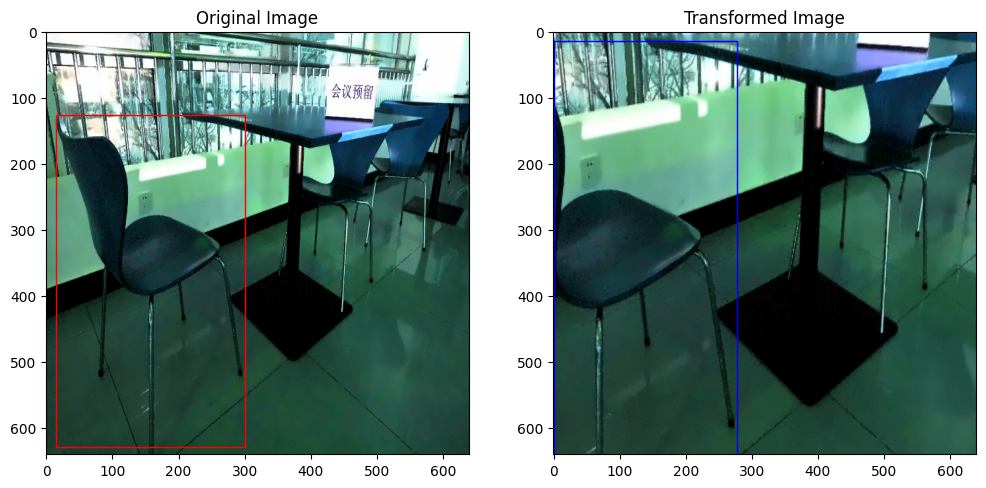

In [20]:
# visualize
def visualize_random_perspective(image, targets, params):
    """
    random_perspective 적용 전후의 이미지를 시각화합니다.
    Args:
        image (ndarray): 원본 이미지.
        targets (ndarray): 타겟 박스.
        params (dict): 변형 파라미터.
    """
    transformed_image, transformed_targets = random_perspective(image.copy(), targets.copy(), params)

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # 원본 이미지
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for t in targets:
        x1, y1, x2, y2 = t[1:]
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
    axes[0].set_title("Original Image")

    # 변환된 이미지
    axes[1].imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    for t in transformed_targets:
        x1, y1, x2, y2 = t[1:]
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='blue', facecolor='none')
        axes[1].add_patch(rect)
    axes[1].set_title("Transformed Image")
    plt.show()

# 예제
dummy_image = cv2.imread('LOD_coco/images/train2017/1001.png')
dummy_image = cv2.cvtColor(dummy_image, cv2.COLOR_BGR2RGB)
dummy_image = cv2.resize(dummy_image, (640, 640))
dummy_targets = np.array([[0, 15, 126, 300, 629]])
visualize_random_perspective(dummy_image, dummy_targets, params)


In [21]:
class Dataset(data.Dataset):
    def __init__(self, filenames, input_size, params, augment):
        self.params = params
        self.mosaic = augment
        self.augment = augment
        self.input_size = input_size

        # 레이블 로드
        cache = self.load_label(filenames)
        labels, shapes = zip(*cache.values())
        self.labels = list(labels)
        self.shapes = np.array(shapes, dtype=np.float64)
        self.filenames = list(cache.keys()) 
        self.n = len(shapes)  
        self.indices = range(self.n)
        self.albumentations = Albumentations()

    def __getitem__(self, index):
        index = self.indices[index]
        params = self.params
        mosaic = self.mosaic and random.random() < params['mosaic']

        if mosaic:
            image, label = self.load_mosaic(index, params)
            # mixup
            if random.random() < params['mix_up']:
                index2 = random.choice(self.indices)
                mix_image2, mix_label2 = self.load_mosaic(index2, params)
                image, label = mix_up(image, label, mix_image2, mix_label2)
        else:
            image, shape = self.load_image(index)
            h, w = image.shape[:2]
            image, ratio, pad = resize(image, self.input_size, self.augment)
            shapes = shape, ((h / shape[0], w / shape[1]), pad)
            label = self.labels[index].copy()
            if label.size:
                label[:, 1:] = wh2xy(label[:, 1:], ratio[0] * w, ratio[1] * h, pad[0], pad[1])
            if self.augment:
                image, label = random_perspective(image, label, params)

        nl = len(label)
        if nl:
            label[:, 1:5] = xy2wh(label[:, 1:5], image.shape[1], image.shape[0])

        if self.augment:
            image, label = self.albumentations(image, label)
            nl = len(label)
            augment_hsv(image, params)
            if random.random() < params['flip_ud']:
                image = np.flipud(image)
                if nl:
                    label[:, 2] = 1 - label[:, 2]
            if random.random() < params['flip_lr']:
                image = np.fliplr(image)
                if nl:
                    label[:, 1] = 1 - label[:, 1]

        target = torch.zeros((nl, 6))
        if nl:
            target[:, 1:] = torch.from_numpy(label)

        sample = image.transpose((2, 0, 1))[::-1]
        sample = np.ascontiguousarray(sample)
        return torch.from_numpy(sample), target, None

    def __len__(self):
        return len(self.filenames)

    @staticmethod
    def collate_fn(batch):
        samples, targets, _ = zip(*batch)
        for i, item in enumerate(targets):
            item[:, 0] = i
        return torch.stack(samples, 0), torch.cat(targets, 0), None

    @staticmethod
    def load_label(filenames):
        path = f'{os.path.dirname(filenames[0])}.cache'
        if os.path.exists(path):
            return torch.load(path)
        x = {}
        for filename in filenames:
            try:
                with open(filename, 'rb') as f:
                    image = Image.open(f)
                    image.verify()
                shape = image.size
                assert (shape[0] > 9) & (shape[1] > 9)
                assert image.format.lower() in ('bmp','dng','jpeg','jpg','mpo','png','tif','tiff','webp')

                a = f'{os.sep}images{os.sep}'
                b = f'{os.sep}labels{os.sep}'
                label_path = b.join(filename.rsplit(a, 1)).rsplit('.', 1)[0] + '.txt'
                if os.path.isfile(label_path):
                    with open(label_path) as f:
                        label = [x.split() for x in f.read().strip().splitlines() if len(x)]
                        label = np.array(label, dtype=np.float32)
                    nl = len(label)
                    if nl:
                        assert label.shape[1] == 5
                        assert (label >= 0).all()
                        assert (label[:, 1:] <= 1).all()
                        _, idx = np.unique(label, axis=0, return_index=True)
                        if len(idx) < nl:
                            label = label[idx]
                    else:
                        label = np.zeros((0, 5), dtype=np.float32)
                else:
                    label = np.zeros((0, 5), dtype=np.float32)
                if filename:
                    x[filename] = [label, shape]
            except FileNotFoundError:
                pass
        torch.save(x, path)
        return x

    def load_image(self, i):
        image = cv2.imread(self.filenames[i])
        h, w = image.shape[:2]
        r = self.input_size / max(h, w)
        if r != 1:
            image = cv2.resize(image, (int(w*r), int(h*r)), interpolation=resample() if self.augment else cv2.INTER_LINEAR)
        return image, (h, w)

    def load_mosaic(self, index, params):
        label4 = []
        image4 = np.full((self.input_size * 2, self.input_size * 2, 3), 0, dtype=np.uint8)
        border = [-self.input_size // 2, -self.input_size // 2]
        xc = int(random.uniform(-border[0], 2 * self.input_size + border[1]))
        yc = int(random.uniform(-border[0], 2 * self.input_size + border[1]))
        indices = [index] + random.choices(self.indices, k=3)
        random.shuffle(indices)
        for i, idx in enumerate(indices):
            img, _ = self.load_image(idx)
            shape = img.shape
            if i == 0:  # top-left
                x1a = max(xc - shape[1], 0)
                y1a = max(yc - shape[0], 0)
                x2a = xc
                y2a = yc
                x1b = shape[1] - (x2a - x1a)
                y1b = shape[0] - (y2a - y1a)
                x2b = shape[1]
                y2b = shape[0]
            elif i == 1:  # top-right
                x1a = xc
                y1a = max(yc - shape[0], 0)
                x2a = min(xc + shape[1], self.input_size * 2)
                y2a = yc
                x1b = 0
                y1b = shape[0] - (y2a - y1a)
                x2b = min(shape[1], x2a - x1a)
                y2b = shape[0]
            elif i == 2:  # bottom-left
                x1a = max(xc - shape[1], 0)
                y1a = yc
                x2a = xc
                y2a = min(self.input_size * 2, yc + shape[0])
                x1b = shape[1] - (x2a - x1a)
                y1b = 0
                x2b = shape[1]
                y2b = min(y2a - y1a, shape[0])
            else:         # bottom-right
                x1a = xc
                y1a = yc
                x2a = min(xc + shape[1], self.input_size * 2)
                y2a = min(self.input_size * 2, yc + shape[0])
                x1b = 0
                y1b = 0
                x2b = min(shape[1], x2a - x1a)
                y2b = min(y2a - y1a, shape[0])

            image4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]
            pad_w = x1a - x1b
            pad_h = y1a - y1b
            lb = self.labels[idx].copy()
            if len(lb):
                lb[:, 1:] = wh2xy(lb[:, 1:], shape[1], shape[0], pad_w, pad_h)
            label4.append(lb)

        label4 = np.concatenate(label4, 0)
        for x in label4[:, 1:]:
            np.clip(x, 0, 2*self.input_size, out=x)
        image4, label4 = random_perspective(image4, label4, params, border)
        return image4, label4


def wh2xy(x, w=640, h=640, pad_w=0, pad_h=0):
    y = np.copy(x)
    y[:, 0] = w * (x[:, 0] - x[:, 2] / 2) + pad_w
    y[:, 1] = h * (x[:, 1] - x[:, 3] / 2) + pad_h
    y[:, 2] = w * (x[:, 0] + x[:, 2] / 2) + pad_w
    y[:, 3] = h * (x[:, 1] + x[:, 3] / 2) + pad_h
    return y


def xy2wh(x, w=640, h=640):
    x[:, [0, 2]] = x[:, [0, 2]].clip(0, w - 1E-3)
    x[:, [1, 3]] = x[:, [1, 3]].clip(0, h - 1E-3)
    y = np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h
    y[:, 2] = (x[:, 2] - x[:, 0]) / w
    y[:, 3] = (x[:, 3] - x[:, 1]) / h
    return y


def resample():
    choices = (cv2.INTER_AREA, cv2.INTER_CUBIC, cv2.INTER_LINEAR, cv2.INTER_NEAREST, cv2.INTER_LANCZOS4)
    return random.choice(choices)


def augment_hsv(image, params):
    h = params['hsv_h']
    s = params['hsv_s']
    v = params['hsv_v']
    r = np.random.uniform(-1, 1, 3) * [h, s, v] + 1
    hh, ss, vv = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    x = np.arange(0, 256, dtype=r.dtype)
    lut_h = ((x * r[0]) % 180).astype('uint8')
    lut_s = np.clip(x * r[1], 0, 255).astype('uint8')
    lut_v = np.clip(x * r[2], 0, 255).astype('uint8')
    im_hsv = cv2.merge((cv2.LUT(hh, lut_h), cv2.LUT(ss, lut_s), cv2.LUT(vv, lut_v)))
    cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=image)


def resize(image, input_size, augment):
    shape = image.shape[:2]
    r = min(input_size / shape[0], input_size / shape[1])
    if not augment:
        r = min(r, 1.0)
    pad = (int(round(shape[1] * r)), int(round(shape[0] * r)))
    w = (input_size - pad[0]) / 2
    h = (input_size - pad[1]) / 2
    if shape[::-1] != pad:
        image = cv2.resize(image, pad, interpolation=resample() if augment else cv2.INTER_LINEAR)
    top, bottom = int(round(h - 0.1)), int(round(h + 0.1))
    left, right = int(round(w - 0.1)), int(round(w + 0.1))
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT)
    return image, (r, r), (w, h)



def mix_up(image1, label1, image2, label2):
    alpha = np.random.beta(32.0, 32.0)
    image = (image1 * alpha + image2 * (1 - alpha)).astype(np.uint8)
    label = np.concatenate((label1, label2), 0)
    return image, label


class Albumentations:
    def __init__(self):
        self.transform = None
        try:
            import albumentations as album
            transforms = [
                album.Blur(p=0.01),
                album.CLAHE(p=0.01),
                album.ToGray(p=0.01),
                album.MedianBlur(p=0.01)
            ]
            self.transform = album.Compose(
                transforms,
                album.BboxParams('yolo', ['class_labels'])
            )
        except ImportError:
            pass

    def __call__(self, image, label):
        if self.transform:
            x = self.transform(image=image, bboxes=label[:,1:], class_labels=label[:,0])
            image = x['image']
            label = np.array([[c, *b] for c, b in zip(x['class_labels'], x['bboxes'])])
        return image, label

In [22]:
def train(num_epochs=10, batch_size=8, pretrained=False):
    """
    Adam optimizer 기반으로 단순화된 학습 루프
    """
    # 1) 모델 준비
    if pretrained:
        ckpt = torch.load(pretrained, map_location='cuda')
        model = ckpt['model'].float()
    else:
        model = yolo_v8_n(num_classes=len(params['names'])).cuda()


    # 2) 데이터셋 준비 (예시는 ./LOD_coco/train.txt 가정)
    filenames = []
    if os.path.exists('./LOD_coco/train2017.txt'):
        with open('./LOD_coco/train2017.txt') as f:
            for line in f.readlines():
                filenames.append(line.strip())
    dataset = Dataset(filenames, 640, params, augment=True)
    loader = data.DataLoader(dataset, batch_size, shuffle=True,
                             num_workers=8, pin_memory=True,
                             collate_fn=Dataset.collate_fn)

    # 3) 옵티마이저 (Adam)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr0'],
                                 weight_decay=params['weight_decay'])

    # 4) loss 함수
    criterion = ComputeLoss(model, params)

    best_map = 0.0

    for epoch in range(num_epochs):
        model.train()
        loss_meter = AverageMeter()
        for images, targets, _ in tqdm(loader, desc=f"[Epoch {epoch+1}/{num_epochs}]"):
            images = images.cuda().float() / 255.
            targets = targets.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            loss_meter.update(loss.item(), images.size(0))

        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {loss_meter.avg:.4f}")

        # 에폭마다 간단히 test 진행
        map50, map_ = test(model)
        print(f"  -> mAP@0.5: {map50:.3f}, mAP@0.5:0.95: {map_:.3f}")
        if map_ > best_map:
            best_map = map_
            ckpt = {'model': copy.deepcopy(model).half()}
            if not os.path.exists('weights'):
                os.makedirs('weights')
            # torch.save(ckpt, './weights/best.pt')
    print("Training done!")


@torch.no_grad()
def test(model=None):
    """
    간단한 평가 루프 (LOD_coco/val.txt 가정)
    """
    if model is None:
        ckpt = torch.load('./weights/best.pt', map_location='cuda')
        model = ckpt['model'].float()

    model.eval()
    filenames = []
    if os.path.exists('./LOD_coco/val2017.txt'):
        with open('./LOD_coco/val2017.txt') as f:
            for line in f.readlines():
                filenames.append(line.strip())

    dataset = Dataset(filenames, 640, params, augment=False)
    loader = data.DataLoader(dataset, batch_size=8, shuffle=False,
                             num_workers=8, pin_memory=True,
                             collate_fn=Dataset.collate_fn)
    iou_v = torch.linspace(0.5, 0.95, 10).cuda()
    n_iou = iou_v.numel()

    metrics = []
    for images, targets, _ in loader:
        images = images.cuda().float() / 255.
        targets = targets.cuda()
        b, _, h, w = images.shape
        outputs = model(images)

        # NMS
        targets[:, 2:] *= torch.tensor((w, h, w, h), device=targets.device)
        outputs = non_max_suppression(outputs, 0.001, 0.65)

        for i, output in enumerate(outputs):
            labels = targets[targets[:, 0] == i, 1:]
            correct = torch.zeros(output.shape[0], n_iou, dtype=torch.bool).cuda()
            if output.shape[0] == 0:
                if labels.shape[0]:
                    metrics.append((correct, *torch.zeros((3, 0)).cuda()))
                continue
            detections = output.clone()
            scale(detections[:, :4], images[i].shape[1:], (h, w), None)
            if labels.shape[0]:
                tbox = labels[:, 1:5].clone()
                tbox[:, 0] = labels[:, 1] - labels[:, 3] / 2
                tbox[:, 1] = labels[:, 2] - labels[:, 4] / 2
                tbox[:, 2] = labels[:, 1] + labels[:, 3] / 2
                tbox[:, 3] = labels[:, 2] + labels[:, 4] / 2
                scale(tbox, images[i].shape[1:], (h, w), None)
                correct_ = np.zeros((detections.shape[0], iou_v.shape[0]), dtype=bool)
                t_tensor = torch.cat((labels[:, 0:1], tbox), 1)
                iou = box_iou(t_tensor[:, 1:], detections[:, :4])
                correct_class = t_tensor[:, 0:1] == detections[:, 5]
                for j in range(len(iou_v)):
                    x = torch.where((iou >= iou_v[j]) & correct_class)
                    if x[0].shape[0]:
                        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
                        if x[0].shape[0] > 1:
                            matches = matches[matches[:,2].argsort()[::-1]]
                            matches = matches[np.unique(matches[:,1], return_index=True)[1]]
                            matches = matches[np.unique(matches[:,0], return_index=True)[1]]
                        correct_[matches[:,1].astype(int), j] = True
                correct = torch.tensor(correct_, dtype=torch.bool, device=iou_v.device)
            metrics.append((correct, output[:, 4], output[:, 5], labels[:, 0]))

    metrics = [torch.cat(x, 0).cpu().numpy() for x in zip(*metrics)]
    if len(metrics) and metrics[0].any():
        tp, fp, p, r, map50, mean_ap = compute_ap(*metrics)
        return map50, mean_ap
    else:
        return 0., 0.


In [ ]:
if __name__ == "__main__":
    # 1) 시드 고정
    setup_seed(0)
    
    # 2) Pretrained 모델 경로
    pretrained = './weights/best.pt'
    
    # 3) 학습
    train(num_epochs=5, batch_size=2, pretrained=pretrained)

[Epoch 1/5] Loss: 3.9028
  -> mAP@0.5: 0.444, mAP@0.5:0.95: 0.269
[Epoch 2/5] Loss: 3.8702
  -> mAP@0.5: 0.416, mAP@0.5:0.95: 0.244
[Epoch 3/5] Loss: 3.7951
  -> mAP@0.5: 0.470, mAP@0.5:0.95: 0.280
[Epoch 4/5] Loss: 3.7910
  -> mAP@0.5: 0.429, mAP@0.5:0.95: 0.262
[Epoch 5/5] Loss: 3.8583
  -> mAP@0.5: 0.447, mAP@0.5:0.95: 0.263
Training done!
